<b>June 24, 2025 • 03:47 PM</b>

In [20]:
#!/usr/bin/env python3
# Panutad Sirikul (French)
# 650510714
# customer_relationship_management
# 229496 Sec DS

# **Thai NLP Categorization Project**

1. Read some admin's remark on problem report
2. Categorize Problem (New Feature) according to keyword in report
3. Manual category checking
4. Presentation slides for CEO

<div class="alert alert-block alert-info">
<b>Note:</b> Use Microsoft Teams for chatting with supervisor for tips and notes</div>

เราอาจจะนำเสนอว่า อันนี้ส่วนใหญ่แม่บ้านมีปัญหา ... โดยมี Root Cause มาจาก ...

### **Importing Dataset**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

# To print all columns
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

# To display the full text in a pandas DataFrame
#pd.set_option("display.max_colwidth", None) # Show full text in each cell

In [22]:
df = pd.read_csv("report_problem_raw.csv")
df.head()

,report_problem_id,professional_id,problem_group,problem_name,report_date,remark
0,7714,1753,คืนงาน / ไม่เข้าให้บริการ,คืนงาน (กะทันหัน),2022-01-01 00:00:00,คุณแม่บ้านคืนงาน smart world แจ้งไม่สะบายค่ะ \...
1,7715,5033,อื่น ๆ,อื่น ๆ,2022-01-01 00:00:00,คุณลุกค้าแจ้งเรื่องเข้ามาว่า คุณแม่บ้านได้โทรห...
2,7716,2363,"ทรัพย์สิน ""เสียหาย""",ทำทรัพย์สินของลูกค้าเสียหาย,2022-01-01 00:00:00,คุณลูกค้าแจ้งว่า คุณแม่บ้านเปิดปิดประตูมุ้งลวด...
3,7717,4379,คืนงาน / ไม่เข้าให้บริการ,คืนงาน (กะทันหัน),2022-01-01 00:00:00,เนื่องจากคุณแม่บ้านกดหัวใจให้คุณลูกค้างานจึงเข...
4,7718,5126,"ทรัพย์สิน ""เสียหาย""",ทำทรัพย์สินของลูกค้าเสียหาย,2022-01-01 00:00:00,5126 : Punika Jantanop คุณลูกค้าแจ้งเข้ามาว่...


In [23]:
df.shape

(27593, 6)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27593 entries, 0 to 27592
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   report_problem_id  27593 non-null  int64 
 1   professional_id    27593 non-null  int64 
 2   problem_group      27592 non-null  object
 3   problem_name       27592 non-null  object
 4   report_date        27593 non-null  object
 5   remark             27592 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.3+ MB


<b>Clean Missing Value</b>

In [25]:
# To check for missing values, use isnull() without quotes and filter rows with any missing values
df[df.isnull().any(axis=1)]

,report_problem_id,professional_id,problem_group,problem_name,report_date,remark
687,8444,3050,NaN,NaN,2022-02-19 00:00:00,NaN


In [26]:
df = df.dropna().reset_index(drop=True)

### <b>Step 1: Text Preprocessing</b>
* Remove punctuation/special characters
* Tokenization (ตัดคำ) - Use `pythainlp.tokenize.word_tokenize()`
* Remove stopwords - Use `pythainlp.corpus.common.thai_stopwords`

In [27]:
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
import string
import re

stopwords = set(thai_stopwords()) - {"ไม่"}

def clean_text(text):
    text = re.sub("เเ", "แ", text)                           # 🛠️ Fix miswritten vowel เเ → แ
    text = re.sub(r'(.)\1{2,}', r'\1', text)                # 🔁 Remove character repetition (e.g. มากกกก → มาก)
    text = re.sub(r'[^\u0E00-\u0E7Fa-zA-Z0-9\s]', '', text) # 🚫 Remove emojis and non-Thai characters (except spaces and numbers)
    return text

def preprocess(text):
    if not isinstance(text, str):
        text = ""
    text = clean_text(text)
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [t for t in tokens if t not in stopwords and t not in string.punctuation]
    return tokens

df["tokens"] = df["remark"].apply(preprocess)


### <b>Step 2: Define Keywords for Each Category</b>
* Create a dictionary with `{"category_name": ["keyword1", "keyword2", ...]}`

In [28]:
# Take a look at each problem group input by service provider
df["problem_group"].unique()

array(['คืนงาน / ไม่เข้าให้บริการ', 'อื่น ๆ', 'ทรัพย์สิน "เสียหาย"',
       'คุณภาพการให้บริการ', 'พฤติกรรมการให้บริการ', 'ทรัพย์สิน "สูญหาย"'],
      dtype=object)

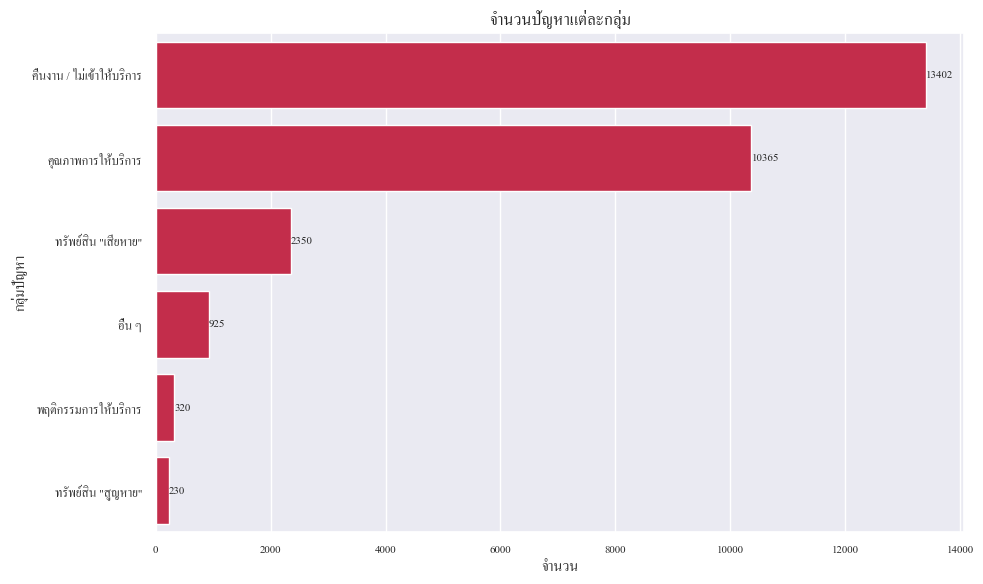

In [34]:
plt.figure(figsize=(10, 6))
sns.set(font="Angsana New")
ax = sns.countplot(
    y="problem_group",
    data=df,
    color="crimson",
    order=df["problem_group"].value_counts().index
)
plt.xlabel("จำนวน", fontsize=14, fontname="Angsana New")
plt.ylabel("กลุ่มปัญหา", fontsize=14, fontname="Angsana New")
plt.title("จำนวนปัญหาแต่ละกลุ่ม", fontsize=16, fontname="Angsana New")
plt.xticks(fontsize=12, fontname="Angsana New")
plt.yticks(fontsize=12, fontname="Angsana New")

# Add exact numbers to bars
for p in ax.patches:
    count = int(p.get_width())
    ax.annotate(f'{count}', 
                (p.get_width(), p.get_y() + p.get_height() / 2),
                va='center', ha='left', fontsize=12, fontname="Angsana New")

plt.tight_layout()
plt.show()

* Use <b>the words from df["tokens"] to help you build the keyword list</b>, but you need to manually decide which words represent which category.
* Use <b>Text Filters in Excel</b> to find keywords from each problem (Optional)

In [35]:
from collections import Counter

In [42]:
# Filter the DataFrame & Flatten the list of tokens
tokens_series = df[df["problem_group"] == 'ทรัพย์สิน "สูญหาย"']["tokens"]
all_tokens = [token for tokens in tokens_series for token in tokens]

word_counts = Counter(all_tokens)
print(word_counts.most_common())

[('\n', 528), ('แม่บ้าน', 416), ('ลูกค้า', 396), ('แจ้ง', 358), ('ไม่', 280), ('หาย', 235), ('เข้ามา', 129), ('ติดต่อ', 90), ('สอบถาม', 82), ('2', 81), ('ให้บริการ', 68), ('ทำความสะอาด', 60), ('ห้อง', 58), ('คน', 57), ('บริการ', 54), ('จอง', 54), ('เงิน', 54), ('กระเป๋า', 53), ('ท่าน', 51), ('วาง', 49), ('บาท', 47), ('ทำ', 47), ('วันที่', 45), ('แชท', 42), ('บ้าน', 42), ('1', 40), ('นะคะ', 36), ('เจอ', 36), ('เบื้องต้น', 36), ('ทราบ', 34), ('ใส่', 31), ('รหัส', 31), ('3', 30), ('หา', 29), ('ต้องการ', 29), ('โทร', 28), ('รบกวน', 28), ('ตรวจสอบ', 28), ('ประสานงาน', 26), ('สูญหาย', 26), ('ขโมย', 25), ('แอดมิน', 25), ('ทิ้ง', 25), ('แน่ใจ', 25), ('งาน', 24), ('ทรัพย์สิน', 24), ('หยิบ', 23), ('ปัญหา', 22), ('ค้า', 21), ('ลุก', 21), ('แหวน', 20), ('หาไม่', 19), ('ทอง', 18), ('สี', 18), ('เวลา', 18), ('เครื่อง', 17), ('ข้อมูล', 17), ('คืน', 17), ('ห้องนอน', 17), ('หน้า', 16), ('ใบ', 16), ('เรื่อง', 16), ('ชม', 16), ('ลิ้นชัก', 15), ('the', 15), ('ห้องน้ำ', 15), ('จ้าง', 15), ('ประสาน', 14), (

In [48]:
keyword_dict = {
    "คืนงาน / ไม่เข้าให้บริการ": ["คืน", "แจ้ง", "สะดวก", "กด", "ยกเลิก", "ไม่สะดวก", "ตอนนี้", "ติดธุระ", 
        "ขอยกเลิก", "ไม่สามารถ", "ขอเลื่อน", "ไม่ว่าง", "กะทันหัน", "ป่วย", "รับงาน", 
        "ไม่ไป", "ติด", "ติดภารกิจ", "ไม่พร้อม", "มีธุระ", "ไม่สะดวกให้บริการ", "ติดงาน",
        "ติดต่อ", "ไม่สามารถให้บริการ", "แม่บ้านไม่ว่าง", "เลื่อน", "วันนี้", "ภารกิจ", 
        "ประสาน", "นัดหมาย", "เลื่อน", "แจ้งล่วงหน้า", "ขอเลื่อน", "เปลี่ยนเวลา", "ไม่สะดวก",
        "ขอเปลี่ยน", "ไม่ว่าง", "ขอเลื่อนเวลา", "ไม่สามารถ", "ต้องเลื่อน", "เลื่อนเวลา", 
        "ยกเลิกนัด", "เปลี่ยนวัน", "นัดใหม่", "วันอื่น", "ขอแจ้ง", "ยกเลิก", "เปลี่ยน", "เลื่อนนัด",
        "โควิด", "โควิด19", "covid", "covid19", "ติดโควิด", "ติดเชื้อ", "ติดไวรัส",
        "กักตัว", "กักบริเวณ", "เสี่ยงสูง", "เสี่ยง", "เจ็บคอ", "ไข้อ่อน", "ไม่สบาย",
        "ไข้", "ไอ", "เหนื่อย", "ไม่สบาย", "ป่วย", "ตรวจโควิด", "ผลตรวจ", "ตรวจเชื้อ",
        "กักตัว14วัน", "กักตัว 14 วัน", "แยกตัว", "ล้มป่วย", "พักรักษา"],
    
    "คุณภาพการให้บริการ": ["ดาว", "รีวิว", "1", "2", "3", "1ดาว", "2ดาว", "3ดาว",
        "ไม่ประทับใจ", "ไม่โอเค", "ไม่พอใจ", "ไม่ดี", "ต้องปรับปรุง", "ควรปรับปรุง",
        "ขอติ", "ข้อติ", "มีข้อเสีย", "พัฒนาด่วน", "ควรพัฒนา", "ต่ำกว่ามาตรฐาน", 
        "บริการไม่ดี", "ความสะอาดไม่ดี", "comment", "feedback", "แย่", "ไม่เรียบร้อย",
        "ไม่ครบ", "พลาด", "ลืม", "ตกหล่น", "รีวิวไม่ดี", "ทำความสะอาด", "ไม่สะอาด", 
        "ไม่เรียบร้อย", "ฝุ่น", "คราบ", "ล้างไม่สะอาด", "เช็ด", "จุด", "ยังมี", "เหลือ",
        "พลาด", "เลอะ", "ไม่ครบ", "ถู", "ล้าง", "ไม่เก็บ", "พื้นสกปรก", "ผนัง", "คราบน้ำ", 
        "พื้นเปียก", "ลืมเช็ด", "ลืมเก็บ", "คุณภาพแย่", "ความสะอาด", "ต้องทำซ้ำ", "พื้นไม่สะอาด", 
        "เก็บงานไม่ดี", "เก็บไม่หมด"],
    
    'ทรัพย์สิน "เสียหาย"': ["ทำเสีย", "ทำตก", "ทำแตก", "ทำพัง", "ทำหล่น", "ทำร่วง", "ร่วง", "แตก", "พัง", "ร้าว", "รอย", 
        "บุบ", "หล่น", "ร่วง", "เสียหาย", "ความเสียหาย", "ทรัพย์สิน", "ข้าวของ", "ของใช้", 
        "ขวด", "แก้ว", "กระจก", "โต๊ะ", "เก้าอี้", "พื้น", "ประตู", "ฝา", "หลอด", 
        "หัก", "หลุด", "เคลม", "ประกัน", "ขอเคลม", "ชดใช้", "เสีย", "ขูด", "ครูด"],
    
    "อื่น ๆ": ["เงินคืน", "ขอเงินคืน", "คืนเงิน", "ขอคืนเงิน", "เงิน", "คืน", "คืนเงินสด",
        "ขอคืน", "คืนยอด", "คืนค่าบริการ", "คืนค่าจอง", "ขอเงิน", "คืนยอดเงิน",
        "เงินคืนให้", "คืนเงินลูกค้า", "เงินสด", "ขอคืนยอด", "คืนค่ามัดจำ", "ลาออก"],
    
    "พฤติกรรมการให้บริการ": ["ก่อนเวลา", "ออกก่อน", "ออกจาก", "ออกก่อนเวลา", "ก่อนกำหนด", "ไม่ครบชั่วโมง",
        "ให้บริการไม่ครบ", "เลิกงานก่อน", "เลิกก่อน", "ออกก่อนกำหนด", "จบก่อน",
        "บริการไม่ครบ", "รีบออก", "เลิกเร็ว", "หยุดก่อน", "เลิกให้บริการก่อน",
        "สาย", "มาสาย", "เข้าช้า", "ช้า", "ถึงช้า", "รอ", "รอนาน", "มาช้า",
        "รอเกิน", "เกินเวลา", "เกินนัด", "รอเป็นชั่วโมง", "เลท", "ไม่ตรงเวลา",
        "มาช้ากว่ากำหนด", "มาเกินเวลา", "ดีเลย์", "ล่าช้า", "ล่าช้ากว่ากำหนด",
        "ไม่มา", "ไม่ไป", "ไม่ให้บริการ", "หาย", "เงียบ", "ไม่ติดต่อ", "ติดต่อไม่ได้", 
        "ไม่รับสาย", "ไม่แจ้ง", "ไม่เข้างาน", "ไม่เข้าหน้างาน", "ขาดงาน", 
        "หายไป", "ไม่มีการแจ้ง", "ไม่ตอบ", "ไม่ปรากฏตัว", "ไม่โผล่", 
        "รับงานแต่ไม่มา", "รับงานแล้วไม่เข้า", "ไม่มาตามนัด", "show"],
    
    'ทรัพย์สิน "สูญหาย"': ["หาย", "สูญหาย", "ของหาย", "ทรัพย์สิน", "หาไม่เจอ", "หาไม่พบ", "ขาดหาย", "หายไป", 
        "ของไม่มี", "ไม่มีของ", "เจอไม่ครบ", "ของหายไป", "ขโมย", "ของขโมย", "ทิ้ง",
        "ไม่เจอ", "หาไม่", "ไม่พบ", "หายหลังใช้บริการ", 
        "วางไว้", "วางหาย", "ลืมไว้", "ของหายหลัง", 
        "missing", "lost", "stolen"]
}

### <b>Step 3: Categorize Based on Keyword Matching</b>
* Match tokens against the keyword list and assign a category

* <b>Score-based categorization</b> that counts how many keywords match per category and picks the category with the highest match count

In [49]:
# 1. Create a function to categorize based on keyword_dict
def categorize_by_keywords(tokens, keyword_dict):
    for group, keywords in keyword_dict.items():
        if any(token in keywords for token in tokens):
            return group
    return "อื่น ๆ"  # Default if no keyword matches

# 2. Apply the function to your DataFrame
df["predicted_group"] = df["tokens"].apply(lambda tokens: categorize_by_keywords(tokens, keyword_dict) if isinstance(tokens, list) else "อื่น ๆ")

# 3. Evaluate accuracy
accuracy = np.mean(df["predicted_group"] == df["problem_group"])
print(f"Keyword matching accuracy: {accuracy:.2%}")

# See confusion matrix for more detail
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(df["problem_group"], df["predicted_group"]))

Keyword matching accuracy: 62.57%
                           precision    recall  f1-score   support

คืนงาน / ไม่เข้าให้บริการ       0.58      0.96      0.73     13402
       คุณภาพการให้บริการ       0.93      0.38      0.54     10365
       ทรัพย์สิน "สูญหาย"       0.00      0.00      0.00       230
      ทรัพย์สิน "เสียหาย"       0.88      0.14      0.25      2350
     พฤติกรรมการให้บริการ       0.01      0.00      0.01       320
                   อื่น ๆ       0.03      0.03      0.03       925

                 accuracy                           0.63     27592
                macro avg       0.41      0.25      0.26     27592
             weighted avg       0.71      0.63      0.58     27592



In [56]:
df

,report_problem_id,professional_id,problem_group,problem_name,report_date,remark,tokens,predicted_group,text
0,7714,1753,คืนงาน / ไม่เข้าให้บริการ,คืนงาน (กะทันหัน),2022-01-01 00:00:00,คุณแม่บ้านคืนงาน smart world แจ้งไม่สะบายค่ะ \...,"[แม่บ้าน, คืน, งาน, smart, world, แจ้ง, ไม่, ส...",คืนงาน / ไม่เข้าให้บริการ,แม่บ้าน คืน งาน smart world แจ้ง ไม่ สะ บาย \n...
1,7715,5033,อื่น ๆ,อื่น ๆ,2022-01-01 00:00:00,คุณลุกค้าแจ้งเรื่องเข้ามาว่า คุณแม่บ้านได้โทรห...,"[ลุก, ค้า, แจ้ง, เรื่อง, เข้ามา, แม่บ้าน, โทร,...",คืนงาน / ไม่เข้าให้บริการ,ลุก ค้า แจ้ง เรื่อง เข้ามา แม่บ้าน โทร หา ลูกค...
2,7716,2363,"ทรัพย์สิน ""เสียหาย""",ทำทรัพย์สินของลูกค้าเสียหาย,2022-01-01 00:00:00,คุณลูกค้าแจ้งว่า คุณแม่บ้านเปิดปิดประตูมุ้งลวด...,"[ลูกค้า, แจ้ง, แม่บ้าน, ปิดประตู, มุ้งลวด, แรง...",คืนงาน / ไม่เข้าให้บริการ,ลูกค้า แจ้ง แม่บ้าน ปิดประตู มุ้งลวด แรง ตอนนี...
3,7717,4379,คืนงาน / ไม่เข้าให้บริการ,คืนงาน (กะทันหัน),2022-01-01 00:00:00,เนื่องจากคุณแม่บ้านกดหัวใจให้คุณลูกค้างานจึงเข...,"[แม่บ้าน, กด, หัวใจ, ลูกค้า, งาน, ระบบ, อัตโนม...",คืนงาน / ไม่เข้าให้บริการ,แม่บ้าน กด หัวใจ ลูกค้า งาน ระบบ อัตโนมัติ แม่...
4,7718,5126,"ทรัพย์สิน ""เสียหาย""",ทำทรัพย์สินของลูกค้าเสียหาย,2022-01-01 00:00:00,5126 : Punika Jantanop คุณลูกค้าแจ้งเข้ามาว่...,"[5126, Punika, Jantanop, ลูกค้า, แจ้ง, เข้ามา,...",คืนงาน / ไม่เข้าให้บริการ,5126 Punika Jantanop ลูกค้า แจ้ง เข้ามา ขา โต๊...
...,...,...,...,...,...,...,...,...,...
27587,36346,11979,คืนงาน / ไม่เข้าให้บริการ,คืนงาน (โครงการป้อนงานคุณแม่บ้าน),2025-05-31 19:16:00,คุณแม่บ้านไม่สะดวกเข้าให้บริการค่ะ,"[แม่บ้าน, ไม่, สะดวก, ให้บริการ]",คืนงาน / ไม่เข้าให้บริการ,แม่บ้าน ไม่ สะดวก ให้บริการ
27588,36347,7992,คุณภาพการให้บริการ,ทำความสะอาดไม่เรียบร้อย,2025-05-31 20:57:00,คุณแม่บ้านไม่ได้มีการจัดเก็บสิ่งของให้คุณลูกค้...,"[แม่บ้าน, ไม่, จัดเก็บ, สิ่งของ, ลูกค้า, ไม่, ...",คุณภาพการให้บริการ,แม่บ้าน ไม่ จัดเก็บ สิ่งของ ลูกค้า ไม่ หน้าต่า...
27589,36353,1112,คุณภาพการให้บริการ,คุณภาพการให้บริการต่ำกว่า 4 ดาว,2025-05-31 23:08:00,"2 ดาว Complain about the room, not organizin...","[2, ดาว, Complain, about, the, room, not, orga...",คุณภาพการให้บริการ,2 ดาว Complain about the room not organizing b...
27590,36356,11973,คุณภาพการให้บริการ,ทำความสะอาดไม่เรียบร้อย,2025-05-31 19:00:00,คุณลูกค้าแจ้งรูปภาพพื้นที่ไม่สะอาดเข้ามาทางแชท,"[ลูกค้า, แจ้ง, รูปภาพ, พื้นที่, ไม่, สะอาด, เข...",คืนงาน / ไม่เข้าให้บริการ,ลูกค้า แจ้ง รูปภาพ พื้นที่ ไม่ สะอาด เข้ามา แชท


# <b>Machine Learning Model</b>

## <b>Logistic Regression</b>

<b>Prepare Data</b>

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Join tokens into a single string for each row
df["text"] = df["tokens"].apply(lambda tokens: " ".join(tokens) if isinstance(tokens, list) else "")

X = df["text"]
y = df["problem_group"]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<b>Vectorize Text</b>

In [51]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

<b>Train Model</b>

In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


<b>Evaluate Model</b>

In [54]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2%}")

print(classification_report(y_test, y_pred))

Model accuracy: 90.92%
                           precision    recall  f1-score   support

คืนงาน / ไม่เข้าให้บริการ       0.95      0.97      0.96      2681
       คุณภาพการให้บริการ       0.91      0.92      0.92      2073
       ทรัพย์สิน "สูญหาย"       0.73      0.76      0.74        46
      ทรัพย์สิน "เสียหาย"       0.89      0.86      0.87       470
     พฤติกรรมการให้บริการ       0.43      0.30      0.35        64
                   อื่น ๆ       0.38      0.28      0.32       185

                 accuracy                           0.91      5519
                macro avg       0.71      0.68      0.69      5519
             weighted avg       0.90      0.91      0.91      5519



# <b>Deep Learning Model</b>

BERT (and its variants like WangchanBERTa for Thai) is a <b>deep learning model</b> that usually outperforms traditional models like logistic regression, especially for complex language tasks. BERT understands context, word order, and subtle meaning, while logistic regression only uses word counts or frequencies.

<b>In conclusion:</b>
* <b>Logistic Regression:</b> Fast, simple, strong baseline for text classification.
* <b>BERT:</b> Much more powerful for nuanced or complex text, but requires more resources (GPU/CPU, memory) and is slower to train/predict

<b>Since this dataset is not large or categories are not subtle, BERT will likely underperform logistic regression.</b>

For small, simple datasets, logistic regression may be sufficient.